## Advanced Mini Project submission(MLEnd classification)

# Author
Student Name: Robert Lennart Manschke
Student ID: 210470194

# 2 Problem formulation

In this notebook we build an ML pipeline to differentiate between 8 segments of popular songs. We use the MLEnd Hums and Whistles dataset, containing hundreds of samples for all segments, in both hummed and whistled form. Classifying both representations(hum&whistle) through the same pipeline is challenging - they have large differences in pitch, noise/clarity and often accuracy. Audio data in general is also interesting because of the large amount of samples, usually in the kHz range. We need to drastically reduce the number of dimensions while still retaining the "essence" for the problem we are trying to solve. One exciting use-case for these methods is smusic recognition from inaccurate, human repetition. If we can differentiate well between 8 songs, then we could probably train the model to be able to recognize many other songs as well. 

In [2]:
import os,zipfile,glob,re
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [3]:
path="data"
os.listdir(path)

['.ipynb_checkpoints', 'ECS7027P Assignment 1 Dataset.zip']

In [4]:

directory_to_extract_to = 'samples_advanced/'
zip_paths = [f for f in os.listdir("data") if f[-4:]==".zip"]
zip_paths=["data/"+path for path in zip_paths]
for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)


In [5]:
#all label folders were manually moved, the containing folder deleted and the _MACOS_X folder deleted.

In [6]:
sample_path = 'samples_advanced/*/*.jpg'
files = glob.glob(sample_path)
num_files=len(files)

In [7]:
print(num_files)

43435


Some students used spaces instead of underscores or brackets around the class, or e.g. 'harrypotter' instead of 'Potter', or switched up the order - we will have to overcome these by adapting the filenames and values

In [8]:
faces_table = [] 

for file in files:
    file_name = "/".join(file.split('/')[-2:])
    try:
        file_data = file.split('/')[-2:]
        emotion_label = file_data[0]
        faces_table.append([file,file_name,emotion_label])
    except IndexError as e:
        print(e)
        print(file_name,file_data)


faces_table[:10]

[['samples_advanced/ANGER/006279.jpg', 'ANGER/006279.jpg', 'ANGER'],
 ['samples_advanced/ANGER/008254.jpg', 'ANGER/008254.jpg', 'ANGER'],
 ['samples_advanced/ANGER/007167.jpg', 'ANGER/007167.jpg', 'ANGER'],
 ['samples_advanced/ANGER/007601.jpg', 'ANGER/007601.jpg', 'ANGER'],
 ['samples_advanced/ANGER/001270.jpg', 'ANGER/001270.jpg', 'ANGER'],
 ['samples_advanced/ANGER/002779.jpg', 'ANGER/002779.jpg', 'ANGER'],
 ['samples_advanced/ANGER/013674.jpg', 'ANGER/013674.jpg', 'ANGER'],
 ['samples_advanced/ANGER/013660.jpg', 'ANGER/013660.jpg', 'ANGER'],
 ['samples_advanced/ANGER/010369.jpg', 'ANGER/010369.jpg', 'ANGER'],
 ['samples_advanced/ANGER/007615.jpg', 'ANGER/007615.jpg', 'ANGER']]

In [9]:
faces_df = pd.DataFrame(faces_table,columns=['file_path','file_name','emotion_label']).set_index('file_name')
display(faces_df)
display(faces_df.nunique())
display(faces_df['emotion_label'].unique())

,file_path,emotion_label
file_name,,
ANGER/006279.jpg,samples_advanced/ANGER/006279.jpg,ANGER
ANGER/008254.jpg,samples_advanced/ANGER/008254.jpg,ANGER
ANGER/007167.jpg,samples_advanced/ANGER/007167.jpg,ANGER
ANGER/007601.jpg,samples_advanced/ANGER/007601.jpg,ANGER
ANGER/001270.jpg,samples_advanced/ANGER/001270.jpg,ANGER
...,...,...
SURPRISE/007618.jpg,samples_advanced/SURPRISE/007618.jpg,SURPRISE
SURPRISE/000611.jpg,samples_advanced/SURPRISE/000611.jpg,SURPRISE
SURPRISE/006260.jpg,samples_advanced/SURPRISE/006260.jpg,SURPRISE


file_path        43435
emotion_label        6
dtype: int64

array(['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE'],
      dtype=object)

In [10]:
faces_df['emotion_label'].value_counts()

SADNESS      13040
HAPPINESS     9113
ANGER         8228
SURPRISE      7418
FEAR          2985
DISGUST       2651
Name: emotion_label, dtype: int64

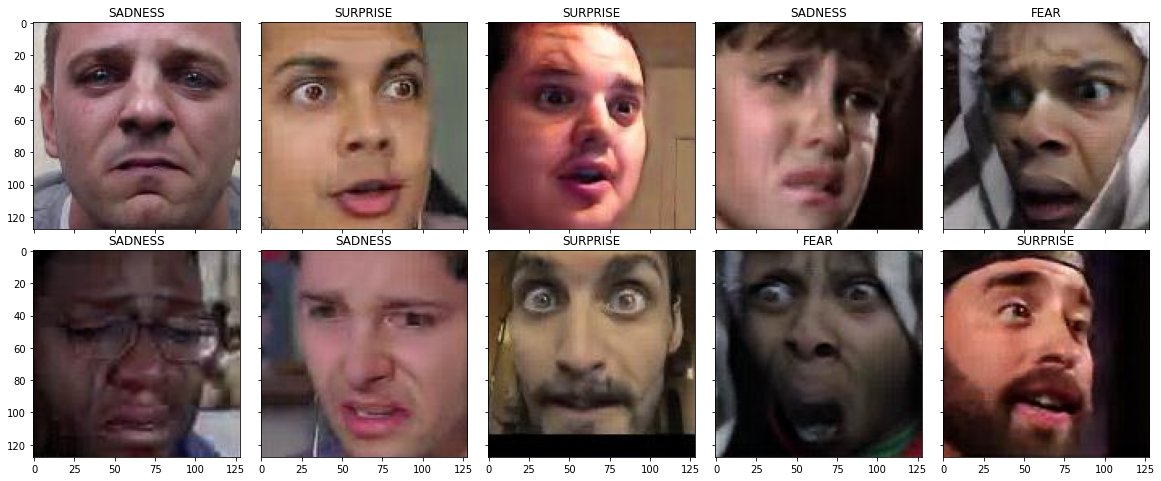

In [11]:
fig, axs = plt.subplots(2,5, figsize=(20,8),sharex=True, sharey=True)
for i in range(10):
    n = np.random.randint(num_files)
    img = mpimg.imread(files[n])
    axs[i//5, i%5].imshow(img)
    axs[i//5,i%5].title.set_text(faces_df.loc["/".join(files[n].split('/')[-2:])]["emotion_label"])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

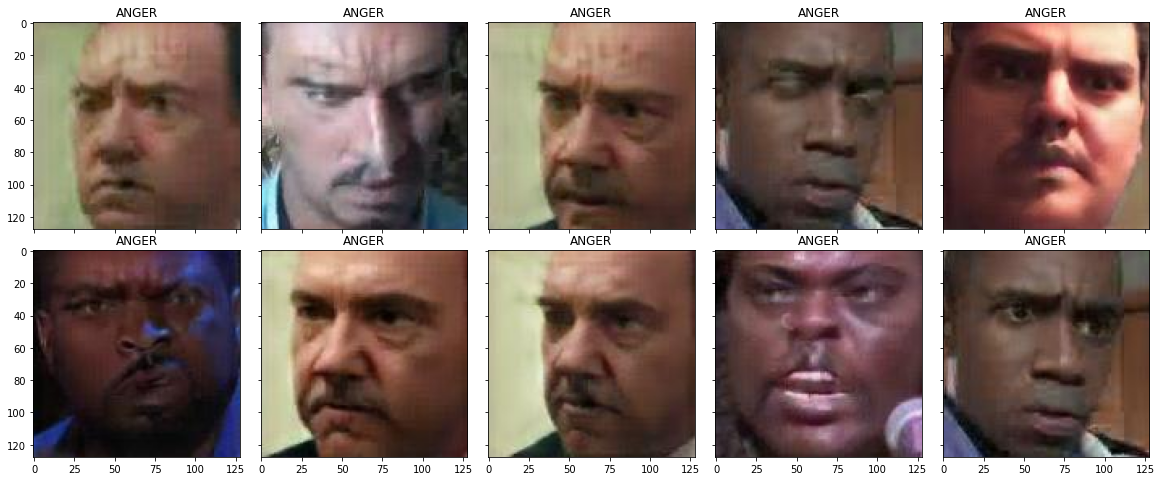

In [12]:
fig, axs = plt.subplots(2,5, figsize=(20,8),sharex=True, sharey=True)
for i in range(10):
    n = i
    img = mpimg.imread(files[n])
    axs[i//5, i%5].imshow(img)
    axs[i//5,i%5].title.set_text(faces_df.loc["/".join(files[n].split('/')[-2:])]["emotion_label"])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [13]:
def show_entry(n):
    return faces_df.loc["/".join(files[n].split('/')[-2:])]

In [14]:
def load_file(file):
    img = mpimg.imread(file)
    return img

file_path        samples_advanced/HAPPINESS/033560.jpg
emotion_label                                HAPPINESS
Name: HAPPINESS/033560.jpg, dtype: object

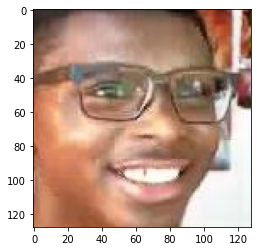

(128, 128, 3)


<BarContainer object of 256 artists>

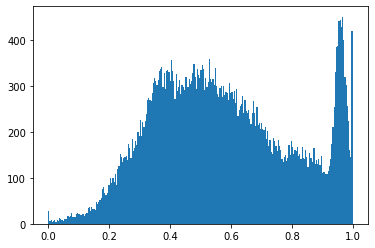

<BarContainer object of 256 artists>

<BarContainer object of 256 artists>

<BarContainer object of 256 artists>

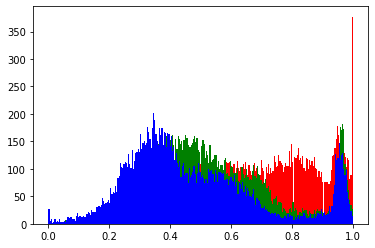

In [15]:
n=15515
img=load_file(files[n])
plt.imshow(img)
display(show_entry(n))
plt.show()
print(img.shape)
display(plt.hist((img/255).ravel(), bins=256)[2])
plt.show()
display(plt.hist((img[:,:,0]/255).ravel(), bins=256,color="red")[2])
display(plt.hist((img[:,:,1]/255).ravel(), bins=256,color="green")[2])
display(plt.hist((img[:,:,2]/255).ravel(), bins=256,color="blue")[2])

In [16]:
def getBrightness(img):
  brightness=img.mean()
  return brightness

In [17]:
getBrightness(img)

147.76932779947916

In [18]:
def scale_minmax(img):
    scaled=(img-img.ravel().min()+1)/(img.ravel().max()-img.ravel().min()+1)
    return scaled

In [19]:
print(getBrightness(scale_minmax(img)))

0.5726259549458822


In [20]:
def remove_shadows(img):
    img=img
    pixel_means=img.mean(axis=2)
    normalized=(img/pixel_means.repeat(3).reshape(img.shape))
    scaled=scale_minmax(normalized)
    scaled*=255
    scaled=scaled.astype(np.uint8)
    return scaled

file_path        samples_advanced/HAPPINESS/049540.jpg
emotion_label                                HAPPINESS
Name: HAPPINESS/049540.jpg, dtype: object

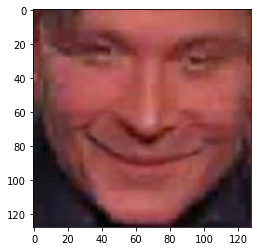

255 63


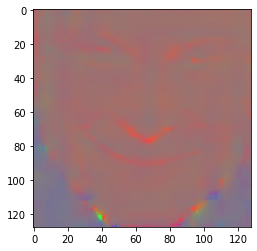

In [21]:
n=15000
img=load_file(files[n])
display(show_entry(n))
plt.imshow(img)
plt.show()
normalized=remove_shadows(img)
print(normalized.ravel().max(),normalized.ravel().min())
plt.imshow(normalized)
plt.show()

In [22]:
def histogramEq(_img):
    img_gray = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    equalized=cv2.equalizeHist(img_gray)
    return equalized

file_path        samples_advanced/HAPPINESS/049540.jpg
emotion_label                                HAPPINESS
Name: HAPPINESS/049540.jpg, dtype: object

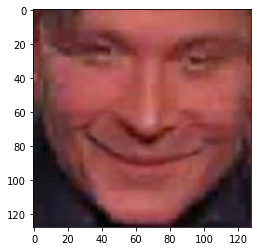

255 0


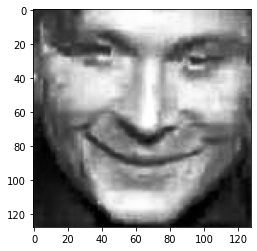

In [23]:
n=15000
img=load_file(files[n])
display(show_entry(n))
plt.imshow(img)
plt.show()
equalized=histogramEq(img)
print(equalized.ravel().max(),equalized.ravel().min())
plt.imshow(equalized,cmap='gray')
plt.show()

In [24]:
def getEdges(img):

    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img, (3,3), 0) 
    
    # Canny Edge Detection
    edges = cv2.Canny(image=img, threshold1=110, threshold2=220) # Canny Edge Detection
    return edges

In [25]:
faces_df.reset_index().index[faces_df["emotion_label"]=="FEAR"]

Int64Index([10879, 10880, 10881, 10882, 10883, 10884, 10885, 10886, 10887,
            10888,
            ...
            13854, 13855, 13856, 13857, 13858, 13859, 13860, 13861, 13862,
            13863],
           dtype='int64', length=2985)

file_path        samples_advanced/ANGER/007601.jpg
emotion_label                                ANGER
Name: ANGER/007601.jpg, dtype: object

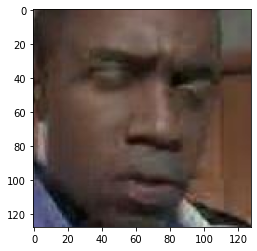

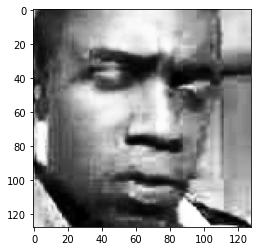

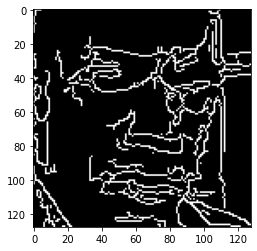

file_path        samples_advanced/DISGUST/004752.jpg
emotion_label                                DISGUST
Name: DISGUST/004752.jpg, dtype: object

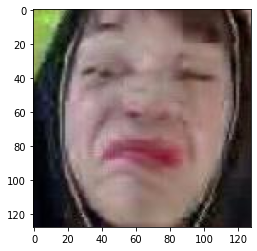

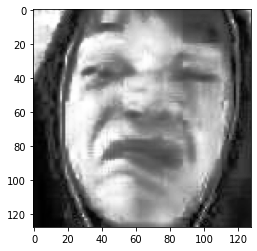

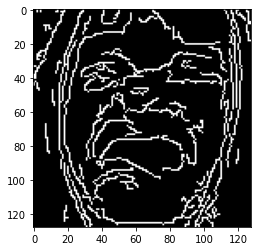

file_path        samples_advanced/FEAR/010036.jpg
emotion_label                                FEAR
Name: FEAR/010036.jpg, dtype: object

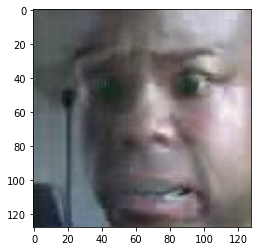

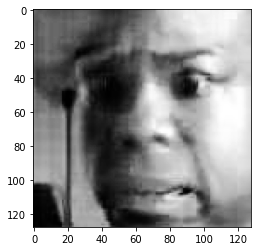

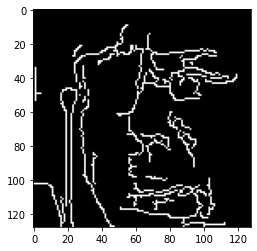

file_path        samples_advanced/HAPPINESS/001227.jpg
emotion_label                                HAPPINESS
Name: HAPPINESS/001227.jpg, dtype: object

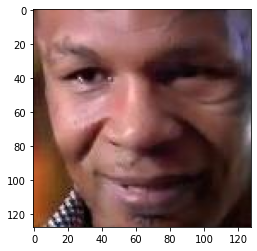

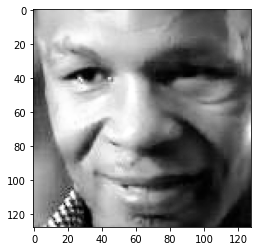

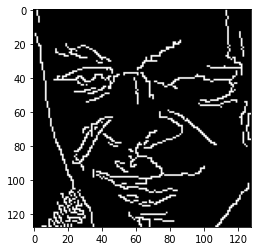

file_path        samples_advanced/SADNESS/080191.jpg
emotion_label                                SADNESS
Name: SADNESS/080191.jpg, dtype: object

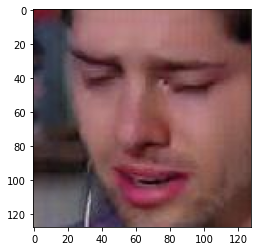

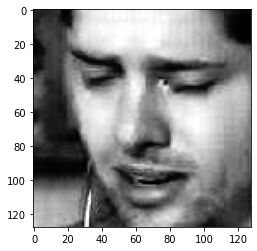

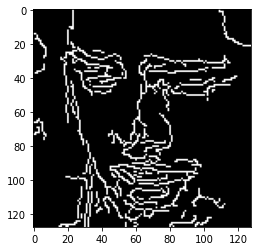

file_path        samples_advanced/SURPRISE/009900.jpg
emotion_label                                SURPRISE
Name: SURPRISE/009900.jpg, dtype: object

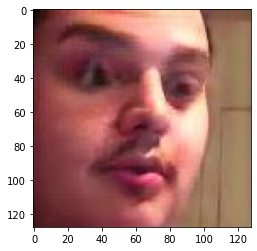

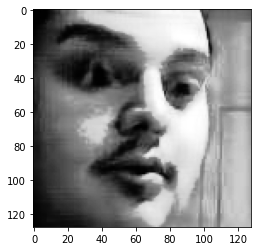

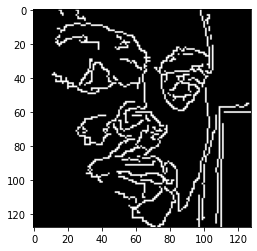

In [26]:
nums=[3,9000,11000,19000,25000,40001]
for n in nums:
    img=load_file(files[n])
    display(show_entry(n))
    plt.imshow(img)
    plt.show()
    normalized=histogramEq(img)
    plt.imshow(normalized,cmap="gray")
    plt.show()
    plt.imshow(getEdges(normalized),cmap="gray")
    plt.show()



In [27]:
img0=load_file(files[5000])
normalized0=histogramEq(img)
mysum=normalized.astype(np.float64)/20000
for file in tqdm(files[20000:40000]):
    img=load_file(file)
    normalized=histogramEq(img)
    mysum+=normalized/20000



100%|██████████| 20000/20000 [00:12<00:00, 1560.42it/s]


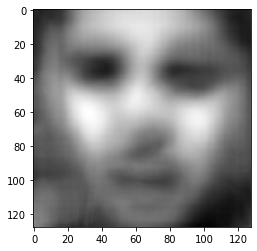

In [28]:
plt.imshow(mysum,cmap="gray")
plt.show()

In [34]:
def getXy(files,labels_file):
  myX,myY =[],[]
  for file in tqdm(files):
    fileID = "/".join(file.split('/')[-2:])
    yi = labels_file.loc[fileID]['emotion_label']

    img = load_file(file)
    scaled_img=scale_minmax(img)
    normalized=scale_minmax(histogramEq(img))
    edges=scale_minmax(getEdges(img))
#     oenv=normalize_pitches(get_main_onsets(getOenv((x,fs),winLen=0.02)))
#     #xi = [filtered,power,pitch_mean,pitch_std]
    xi = np.[normalized,edges]
    myX.append(xi)
    myY.append(yi)

  return np.array(myX),np.array(myY)

SyntaxError: invalid syntax (487507180.py, line 13)

In [33]:
del X
del y

In [35]:

X,y=getXy(files[::40], labels_file=faces_df)

100%|██████████| 1086/1086 [00:09<00:00, 119.73it/s]


In [36]:
with open('X_and_y_preprocessed_1k.npy', 'wb') as f:
    np.save(f, X)
    np.save(f, y)

In [31]:
 X,y=getXy(files, labels_file=faces_df)

100%|██████████| 43435/43435 [01:03<00:00, 686.76it/s]


save to/load from file to save time when restarting the kernel

In [32]:
with open('X_and_y_preprocessed_all.npy', 'wb') as f:
    np.save(f, X)
    np.save(f, y)

In [37]:
with open('X_and_y_preprocessed_2k.npy', 'rb') as f:
    X=np.load(f,allow_pickle=True)
    y=np.load(f,allow_pickle=True)

sanity check

In [38]:
X= X.flatten().reshape(X.shape[0], np.prod(X.shape[1:]))
print(X.shape,y.shape)

(1086, 32768) (1086,)


as the pitch feature takes very long to extract, I started saving only pitch and adding other features, and combining them like this to retain time coherence

In [ ]:
# Xnew=[]
# for i in range(len(X)):
#     Xnew.append(np.array([X[i],Xadded[i]]).T)
# Xnew=np.array(Xnew)

In [ ]:
# print(Xnew.shape)

In [39]:
ydf=pd.DataFrame(y)
ydf
ydf.value_counts()

SADNESS      326
HAPPINESS    228
ANGER        206
SURPRISE     185
FEAR          75
DISGUST       66
dtype: int64

In [40]:
print(X[1].shape)

(32768,)


In [41]:
for i,seq in enumerate(X):
    if np.isnan(seq).all():
        print(i,seq)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y.shape)


# 5 Modelling 
I am experimenting with these scikit-learn models(I also varied the hidden layer structures of the MLP and some of the other classifier's parameters more than the listed instances):
```
[lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(50,)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(25,)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(16,)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(32,)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(100,)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(100,50)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(50,25)),
lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(100,50,25)),
lambda:linear_model.SGDClassifier(alpha=0.0001),
lambda:KNeighborsClassifier(n_neighbors=2),
lambda:KNeighborsClassifier(n_neighbors=4),
lambda:KNeighborsClassifier(n_neighbors=6),
lambda:KNeighborsClassifier(n_neighbors=8),
lambda:KNeighborsClassifier(n_neighbors=10),
lambda:KNeighborsClassifier(n_neighbors=11),
lambda:KNeighborsClassifier(n_neighbors=12),
lambda:KNeighborsClassifier(n_neighbors=13),
lambda:KNeighborsClassifier(n_neighbors=14),
lambda:KNeighborsClassifier(n_neighbors=15),
lambda:KNeighborsClassifier(n_neighbors=16),
lambda:KNeighborsClassifier(n_neighbors=17),
lambda:KNeighborsClassifier(n_neighbors=18),
lambda:KNeighborsClassifier(n_neighbors=19),
lambda:DecisionTreeClassifier(max_depth=10),
lambda:RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
lambda:AdaBoostClassifier(),]
```
but even changin some of them up, it always kept coming back to kNearestNeighbours with 4-8 neighbors being the best model at around 67 percent accuracy:
```
Training accuracy mean: 0.7882352941176471
Validation accuracy mean: 0.6692599620493359
Training accuracy min: 0.7775142314990512
Training accuracy max: 0.7964895635673624
Validation accuracy min: 0.6432637571157496
Validation accuracy max: 0.7020872865275142
fitting model to whole training dataset
accuracy: 0
KNeighborsClassifier(n_neighbors=4)
testing best model on val. dataset:
0.6737481031866465
```
Sometimes, a few of the models randomly achieve a higher accuracy because of a favourable train/test split; the highest I have encountered is >71 percent.The entire loop, with all the different models and 10 initializations each, has not failed to produce a model with at least 90 percent accuracy so far (given an 80:20 split of training to validation data), and I have run the tryManyMethods function about 20 times now. I think these results are somewhat lacking, but I was unable to improve the performance even with more complex models. It seems that an MLP model's accuracy is highly random. An 80:20 split is somewhat arbitrary, I decided that around 160 test samples should be enough to remain somewhat objective. I kept this split at 80:20 even for the second split of train data in the train_loop because it resulted in better performance of the final model, even though a 75:25 split would be more appropriate to keep the same absolute number of validation samples between validation datasets. 

The shallow MultiLayerPerceptrons fail to fit the training data better than kNN, and the deeper MLPs quickly overfit the training data, leaving them very slightly behind. Adapting the MLP model such that the number of parameters is a bit lower than the number of samples seems to be the best take, but it still doesn't improve accuracy beyond other methods. The other classifiers at the bottom of the list are also similar in performance.
Since MLP is more computationally complex and the other classifiers come out on top less often with different splits of the 824 set (I split the data twice, once for the model selection out of 10 initializations and once for selecting the best method(kNN,MLP,etc)).





Additionally to the above, I also tried an LSTM-based approach with and without a convolutional layer to see if I can get better performance by using purpose built methods for sequences and whether convolution will help me detect unique shorter sequences regardless of time. Unfortunately this was unsuccessfull.
I also added a transformer-based model, the "state of the art" of sequence classificiation, which was marginally better at generalising(i.e. validation score was better even though the training score was the same or worse), but still way worse than kNN. I might write more on these two in the results section.

I also tried using the lstm and transformer models on an earlier stage in transformation( the truncated getPitch output), but the model was very very slow to train (in terms of epochs as well as time), so I don't presume it was successfull 

I took the code for both from the first online article about lstm and transformer classification I could find and tried to modify them to my needs. This is my effort to try something new, and after a lot of modification it worked, somewhat, but I think the high parameter count makes it very difficult to train these models well without being an expert in their application
 I

# 6 Methodology

I decided to train each model with 10 different splits of the training data to exclude the possibility of a "lucky" split for one model which doesn't occur for another model. This way, I hope to see how robust each method is. I first did 50 splits for each model, but it became clear that 10 are sufficient. While the overall performance across all models is still reliant on the initial split into training and test data, I have a solid comparison of different models this way. I wanted to mostly reward a high accuracy and see which method can come up with the highest accuracy, rather than choosing a method based on robustness, but I was also interested in robustness, so I printed both but selected the best model based on accuracy, not based on the highest "lowest accuracy".
After selecting the best model, I do a partial fit it to the whole training data to increase accuracy even further. Different methods are evaluated the same way(based on accuracy) and finally the best model&method is selected. 

Accuracy is a good metric for this dataset because it is distributed almost equally

I also show the confusion matrix for the final model to see whether the model prefers one class over the other.

I decided to split 80:20 both times even though it would be more correct to split based on the absolute number of validation samples. My reasoning is empirical - I tried 70:30, 90:10 and a matching absolute numbers and the 80:20 split just resulted in low variance in validation with highly performing models. 80:20 splitting is the popular choice, so I assume this is the usual result as well.

For the LSTM and Transformer models, I simply took the accuracy and confusion matrix, as their training process is a bit different and they don't match the performance of the other models for this number of samples, this dataset or this configuration

In [54]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [56]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X.shape,y.shape)

(868, 32768) (868,) (218, 32768) (218,) (1086, 32768) (1086,)


In [57]:
def train_loop(lX,ly,num_init_models,modelfn):
    val_sum=0
    train_sum=0
    train_min=1.0
    train_max=0.0
    val_min=1.0
    val_max=0.0
    best_model=None
    for _ in tqdm(range(num_init_models)):
        lX_train, lX_val, ly_train, ly_val = train_test_split(lX,ly,test_size=0.2)
        lX_train.shape, lX_val.shape, ly_train.shape, ly_val.shape

        lX_train = (lX_train)
        lX_val  = (lX_val)

        model=modelfn()
        model.fit(lX_train,ly_train)
        yt_p = model.predict(lX_train)
        yv_p = model.predict(lX_val)
        train_acc=np.mean(yt_p==ly_train)
        val_acc=np.mean(yv_p==ly_val)
        if train_acc>train_max:
            train_max=train_acc
        if train_acc <train_min:
            train_min=train_acc
        if val_acc>val_max:
            val_max=val_acc
            best_model=model
        if val_acc<val_min:
            val_min=val_acc
        train_sum+=train_acc
        val_sum+=val_acc

    print("Training accuracy mean:",train_sum/num_init_models)
    print("Validation accuracy mean:",val_sum/num_init_models)
    print("Training accuracy min:",train_min)
    print("Training accuracy max:",train_max)
    print("Validation accuracy min:",val_min)
    print("Validation accuracy max:",val_max)
    acc=0
    print("fitting model to whole training dataset")
    if hasattr(best_model,'partial_fit'):
        it=0
        while acc!=1.0 and it<1000:
            best_model.partial_fit(lX,ly)
            y_p=best_model.predict(lX)
            acc=np.mean(y_p==ly)
            it+=1
    print("accuracy:",acc)
    return (best_model,acc)

In [58]:
def tryManyMethods(X_train,y_train,X_val,y_val):
    options=[lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=()),
        lambda:MLPClassifier(max_iter=10000,learning_rate='constant',hidden_layer_sizes=(50,))]
    bestacc=0
    bestmodel=None
    bestoption=None
    for fn in options:
        model,acc= train_loop(X_train,y_train,10,modelfn=fn)
        print(model)
        print("testing best model on val. dataset:")
        y_p=model.predict(X_val)
        acc=np.mean(y_p==y_val)
        print(acc)
        if acc>bestacc:
            bestacc=acc
            bestmodel=model
            bestoption=fn
    print(bestmodel)
    model=bestmodel
    return model


In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
def eval_model(model,X_val,y_val):
    print(y_val.shape)
    print("testing best model with validation dataset:")
    y_p=model.predict(X_val)
    acc=np.mean(y_p==y_val)
    print(acc)
    ConfusionMatrixDisplay.from_predictions(y_val,y_p)

# for wrong in wrongs:
#     show_entry(wrong)
#     x,fs=load_file(files[wrong])
#     plot_file(x,fs)
#     plt.show()
#     display(ipd.Audio(files[wrong]))
#     pitches,voiced_flag=getPitch(x,fs)
#     plot_pitches(pitches)
#     plt.show()
#     plot_pitches(get_main_pitches(pitches))
#     plt.show()




# 8 Results

Carry out your experiments here, explain your results.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
ytdf=pd.DataFrame(y_train)
ytdf
print(ytdf.value_counts())
yvdf=pd.DataFrame(y_val)
yvdf
print(yvdf.value_counts())
model=tryManyMethods(X_train,y_train,X_val,y_val)


SADNESS      252
HAPPINESS    185
ANGER        164
SURPRISE     150
FEAR          61
DISGUST       56
dtype: int64
SADNESS      74
HAPPINESS    43
ANGER        42
SURPRISE     35
FEAR         14
DISGUST      10
dtype: int64


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
eval_model(model,X_val,y_val)

Trying the same with the rhythm values, I hoped  the performance would improve

In [ ]:
XnewSk=[]
for x in Xnew:
    XnewSk.append(x.ravel())
XnewSk=np.array(XnewSk)
print(XnewSk.shape)
print(XnewSk[0][1],Xnew[0][0][1])

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(XnewSk,y,test_size=0.2)
ytdf=pd.DataFrame(y_train)
ytdf
print(ytdf.value_counts())
yvdf=pd.DataFrame(y_val)
yvdf
print(yvdf.value_counts())
model=tryManyMethods(X_train,y_train,X_val,y_val)

In [ ]:
eval_model(model,X_val,y_val)

But I was uinable to seee any improvement, in fact running tryManyMethods many times I ended up with worse results. I assume this is because the addition of redundant data adds complexity to the problem that the model cannot solve, as explained in the basic solution

In [ ]:
print(X_train.shape)

adding 

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
def getXyPurePitch(files,labels_file, scale_audio=False, onlySingleDigit=False):
  myX,myy =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song']

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0 = getPitch((x,fs),winLen=0.02) 
    f0=normalize_pitches(f0)
    
    xi = f0
    myX.append(xi)
    myy.append(yi)

  return np.array(myX),np.array(myy)

In [ ]:
Xpure,_=getXyPurePitch(files[::1000], labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

In [ ]:

with open('X_purepitch_broad_all.npy', 'rb') as f:
    Xpure=np.load(f,allow_pickle=True)

In [ ]:
print(Xpure.shape)

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Flatten
from keras.layers import Input
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras import backend as K
import tensorflow as tf

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
# truncate and pad input sequences
input_shape = 50 #1500

X_train= sequence.pad_sequences(X_train, maxlen=input_shape)
X_val= sequence.pad_sequences(X_val, maxlen=input_shape)
# create the model
embedding_vector_length = 15
model = Sequential()
encoder = LabelBinarizer()
y_transformed = encoder.fit_transform(y_train)
y_val_transformed = encoder.fit_transform(y_val)
model.add(Conv1D(filters=64, kernel_size=5,strides=1, padding='same', activation='relu',input_shape=(input_shape, 1)))
#model.add(Conv1D(filters=64, kernel_size=10,strides=1, padding='same', activation='relu'))
model.add(LSTM(50))
model.add(Dense(8, activation='sigmoid'))
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

In [ ]:
print(X_train.shape)

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.99
    decay_step = 10
    if epoch==0:
        return 0.01
    if lr<=0.00001:
        return lr
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    
    return lr
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

In [ ]:
model.fit(X_train, y_transformed, epochs=300,callbacks=callbacks, batch_size=32)

In [ ]:
scores = model.evaluate(X_val, y_val_transformed, verbose=0)
print(scores)
print(model.metrics_names)

In [ ]:
def eval_model_keras(model,X_val,y_val):
    print(y_val.shape)
    print("testing best model with validation dataset:")
    y_p=model.predict(X_val)
    acc=np.mean(y_p==y_val)
    print(acc)
    ylabels=encoder.inverse_transform(y_val)
    ypred=encoder.inverse_transform(y_p)
    ConfusionMatrixDisplay.from_predictions(ylabels,ypred)

In [ ]:
eval_model_keras(model,X_val,y_val_transformed)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
n_classes=8
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)
input_shape = (50,1)

model = build_model(
    input_shape,
    head_size=32,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"],
)
model.summary()



In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.99
    decay_step = 10
    if epoch==0:
        return 0.01
    if lr<=0.00001:
        return lr
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    
    return lr
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

X_train= sequence.pad_sequences(X_train, maxlen=input_shape[0])
X_val= sequence.pad_sequences(X_val, maxlen=input_shape[0])
y_transformed = encoder.fit_transform(y_train)
y_val_transformed = encoder.fit_transform(y_val)


In [ ]:
print(X_train.shape)

In [ ]:
keras.backend.clear_session()

In [ ]:

model.fit(
    X_train,
    y_transformed,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=callbacks
)




In [ ]:
model.evaluate(X_val, y_val_transformed, verbose=1)


In [ ]:
eval_model_keras(model,X_val,y_val_transformed)

In [ ]:
def get_wrongs(model,X_val,y_val):
    y_p=model.predict(X_val)
    return [y_val[x] for x in np.where(y_p!=y_val)[0]]


In [ ]:
get_wrongs(model,X_val,y_val)

In [ ]:
def normalize_audio(tup):
    (x,fs)=tup
    return (x/np.max(np.abs(x)),fs)

In [ ]:
def isPotterToLabel(isPotter):
    return "Potter" if isPotter else "StarWars"

In [ ]:

def run_pipeline(pipeline,input_file):
    inputs=input_file
    for fn in pipeline:
        inputs=fn(inputs)
    return inputs

In [ ]:
def make2darray(array):
    return np.array(array,ndmin=2)

In [ ]:
pipeline=[
    load_file,
    normalize_audio,
    getPitch,
    get_main_pitches,
    normalize_pitches,
    make2darray,
    model.predict,
    isPotterToLabel
]

In [ ]:
print(run_pipeline(pipeline,files[0]))

In [ ]:
filenames=[]
outputs=[]
count=0
for file in files[::90]:
    filenames.append(file)
for file in tqdm(files[::90]):
    result=run_pipeline(pipeline,file)
    fileID = file.split('/')[-1]
    if result!=MLENDHW_df.loc[fileID]['song']:
        count+=1
    outputs.append(result)
print(filenames)
print(outputs, "("+str(count)+" wrong)")

It does take 3.5 seconds per song on my laptop, a large part of which is due to the pitch extraction across a wide range of frequencies(since both whistles and hums need to be respected). The model only got one sample wrong, right in line with the validation accuracy; to be fair, training data is included in this example as well, it is just an example of running the pipeline on multiple files.

Now that we are happy with our pipeline, we should train the model using all data we have and update the pipeline with the new model

In [ ]:
#model.fit(X,y)
#eval_model(model,X,y)
# pipeline=[
#     load_file,
#     normalize_audio,
#     getPitch,
#     get_main_pitches,
#     normalize_pitches,
#     make2darray,
#     model.predict,
#     isPotterToLabel
# ]

# 7 Dataset

The dataset and some visualizations are shown in the other sections, especially problem formulatioun and tranformation.

# 8 Results

As with the basic solution, the best model was the simplest one - kNN exceeded in performance and beat all other methods I tested. I thiink this could partly be due to the nature of the dataset.
Tranformers were better than LSTMs, but both performed way worse than kNN.

# 9 Conclusions
I was able to predict the StarWars vs HarryPotter problem at >67% accuracy using my model. I think this is not really satisfactory, but still much higher than randomly guessing, which would be 12.5%. One way I might have been able to boost my results is by filtering at least the training data for good samples. The model would be better at recognizing "good" humming, but probably worse at recognizing "bad" humming. Since the majority of the hums in the dataset are subjectively at least mediocre, I think this would have still increased the validation score, or at least increased the "understandability" of the score ("The model is bad at recognizing songs when they are hummed badly"). Another way to improve results would have been to augment the dataset artifically, especially for the transformer and convolutional-LSTM model, e.g. by splitting the samples into multiple parts, adding padding etc. 